In [116]:
import numpy as np

def ridge_regression(X, y, lam):
    n, d = X.shape
    
    # Add bias term by appending a column of ones
    X_tilde = np.hstack([X, np.ones((n, 1))])
    
    # Construct regularization matrix (do not regularize bias term)
    reg = 2 * lam * np.eye(d + 1)
    reg[-1, -1] = 0  
    
    # Closed-form solution: (X^T X + reg)^(-1) X^T y
    A = X_tilde.T @ X_tilde + reg
    b_vec = X_tilde.T @ y
    w_tilde = np.linalg.solve(A, b_vec)
    
    w = w_tilde[:-1]
    b = w_tilde[-1]
    
    return w, b


In [117]:
import numpy as np

def ridge_regression_gd(X, y, lam=1.0, eta=0.01, max_pass=1000, tol=1e-5):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    losses = []

    for t in range(max_pass):
        # Compute predictions
        y_pred = X @ w + b
        
        # Compute gradients
        grad_w = (1/n) * X.T @ (y_pred - y) + 2 * lam * w
        grad_b = (1/n) * np.sum(y_pred - y)
        
        # Update parameters
        w_new = w - eta * grad_w
        b_new = b - eta * grad_b
        
        # Compute loss (consistent with compute_loss function)
        mse = (1/n) * np.sum((y_pred - y)**2)  # Standard MSE without the 1/2 factor
        regularization = lam * np.sum(w**2)
        loss = mse + regularization
        losses.append(loss)
        
        # Check convergence
        if np.linalg.norm(w_new - w) <= tol:
            w, b = w_new, b_new
            break
        
        w, b = w_new, b_new
    

    return w, b, losses


--- λ = 0 ---
Closed-form:
 Training Error: 9.69429863890932
 Training Loss : 9.69429863890932
 Test Error    : 370.222957298433
 Time          : 0.000370025634765625 s
Gradient descent:
 Training Error: 10.02168615688538
 Training Loss : 10.02168615688538
 Test Error    : 172.99542058141117
 Time          : 0.013561010360717773 s

--- λ = 2 ---
Closed-form:
 Training Error: 9.711966530146903
 Training Loss : 109.0461782997462
 Test Error    : 320.8766717632407
 Time          : 7.700920104980469e-05 s
Gradient descent:
 Training Error: 62.96144309495101
 Training Loss : 69.91283555325397
 Test Error    : 43.16429700201442
 Time          : 0.0023450851440429688 s

--- λ = 4 ---
Closed-form:
 Training Error: 9.757922397503231
 Training Loss : 198.9703631105295
 Test Error    : 281.98578138627505
 Time          : 3.504753112792969e-05 s
Gradient descent:
 Training Error: 153.1073927233596
 Training Loss : 158.4488557942555
 Test Error    : 78.8940410086023
 Time          : 0.001291036605

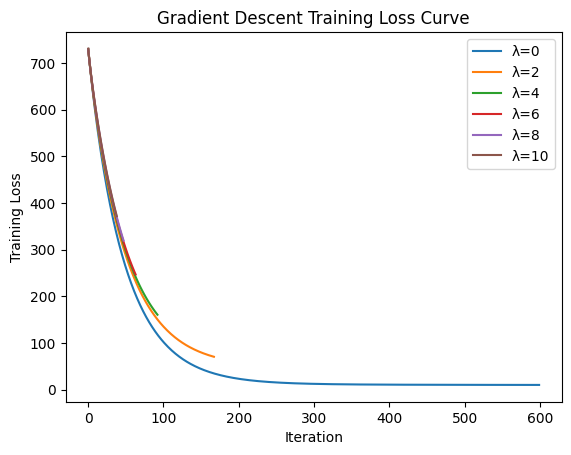

In [120]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Standardization function
# ----------------------------
def standardize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    std[std == 0] = 1.0  # Prevent division by zero
    train_std = (train - mean) / std
    test_std = (test - mean) / std
    return train_std, test_std

# ----------------------------
# Using functions from previous cells
# ----------------------------
# ridge_regression from Cell 1 (closed form)
# ridge_regression_gd from Cell 3 (gradient descent)

# ----------------------------
# Error & Loss
# ----------------------------
def compute_error(X, y, w, b):
    y_pred = X @ w + b
    return np.mean((y_pred - y)**2)

def compute_loss(X, y, w, b, lam):
    n = X.shape[0]
    y_pred = X @ w + b
    mse = (1/n) * np.sum((y_pred - y)**2)  # Standard MSE without the 1/2 factor
    regularization = lam * np.sum(w**2)
    return mse + regularization

# ----------------------------
# Main Experiment
# ----------------------------
# Load housing dataset from CSV files
# Load without headers first to check raw dimensions
X_train_df = pd.read_csv("./a1-files/housing_X_train.csv", header=None)
X_test_df = pd.read_csv("./a1-files/housing_X_test.csv", header=None)
y_train_df = pd.read_csv("./a1-files/housing_y_train.csv", header=None)
y_test_df = pd.read_csv("./a1-files/housing_y_test.csv", header=None)

# Convert to numpy and transpose
X_train = X_train_df.values.T
X_test = X_test_df.values.T
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

# Fix sample count mismatch
min_train_samples = min(X_train.shape[0], y_train.shape[0])
min_test_samples = min(X_test.shape[0], y_test.shape[0])

X_train = X_train[:min_train_samples, :]
y_train = y_train[:min_train_samples]
X_test = X_test[:min_test_samples, :]
y_test = y_test[:min_test_samples]

# Standardize
X_train_std, X_test_std = standardize(X_train, X_test)

for lam in range(0,11,2):  # Include λ=0 to see unregularized baseline
    print(f"\n--- λ = {lam} ---")
    
    # Closed form (using function from Cell 1)
    t0 = time.time()
    w_cf, b_cf = ridge_regression(X_train_std, y_train, lam)
    t_cf = time.time() - t0
    
    train_error_cf = compute_error(X_train_std, y_train, w_cf, b_cf)
    train_loss_cf = compute_loss(X_train_std, y_train, w_cf, b_cf, lam)
    test_error_cf = compute_error(X_test_std, y_test, w_cf, b_cf)
    
    print("Closed-form:")
    print(" Training Error:", train_error_cf)
    print(" Training Loss :", train_loss_cf)
    print(" Test Error    :", test_error_cf)
    print(" Time          :", t_cf, "s")
    
    # Gradient descent (using function from Cell 2)
    t0 = time.time()
    w_gd, b_gd, losses = ridge_regression_gd(X_train_std, y_train, lam=lam, eta=0.01, max_pass=600)
    t_gd = time.time() - t0
    
    train_error_gd = compute_error(X_train_std, y_train, w_gd, b_gd)
    train_loss_gd = compute_loss(X_train_std, y_train, w_gd, b_gd, lam)
    test_error_gd = compute_error(X_test_std, y_test, w_gd, b_gd)
    
    print("Gradient descent:")
    print(" Training Error:", train_error_gd)
    print(" Training Loss :", train_loss_gd)
    print(" Test Error    :", test_error_gd)
    print(" Time          :", t_gd, "s")
    
    # Plot training loss curve
    plt.plot(losses, label=f"λ={lam}")
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.title("Gradient Descent Training Loss Curve")
    plt.legend()


plt.show()